# Fashion Detail Preverser via MamaNet

## Step 1: Import Necessary Libraries

In [1]:
print("Step1")
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image

Step1


## Step 2: Define the MamaNet Model

In [2]:
print("Step2")
class MamaNet(nn.Module):
    def __init__(self):
        super(MamaNet, self).__init__()

        self.encoder1 = self.double_conv(3, 64)
        self.encoder2 = self.double_conv(64, 128)
        self.encoder3 = self.double_conv(128, 256)
        self.encoder4 = self.double_conv(256, 512)
        self.bottleneck = self.double_conv(512, 1024)

        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.decoder4 = self.double_conv(1024, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder3 = self.double_conv(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder2 = self.double_conv(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder1 = self.double_conv(128, 64)

        self.final_conv = nn.Conv2d(64, 3, kernel_size=1)

    def double_conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.downsample(enc1))
        enc3 = self.encoder3(self.downsample(enc2))
        enc4 = self.encoder4(self.downsample(enc3))
        bottleneck = self.bottleneck(self.downsample(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)

        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)

        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)

        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)

        return torch.sigmoid(self.final_conv(dec1))

    def downsample(self, x):
        return nn.MaxPool2d(kernel_size=2, stride=2)(x)

Step2


## Step 3: Load and Preprocess the Dataset

In [3]:
print("Step3")
class DummyFashionDataset(Dataset):
    def __init__(self, num_samples=100, img_size=(128, 128)):
        self.num_samples = num_samples
        self.img_size = img_size
        self.transform = transforms.Compose([
            transforms.ToTensor(),
        ])

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        # Generate dummy data: Random images and "masks"
        image = np.random.rand(*self.img_size, 3).astype(np.float32)
        mask = image  # In practice, this should be your ground truth mask

        image = self.transform(image)
        mask = self.transform(mask)

        return image, mask

Step3


In [9]:
class ToyFashionDataset(Dataset):
    def __init__(self, root_dir="/content/drive/MyDrive/Projects/ToyFashionDataset"):
        self.root_dir = root_dir
        self.cloth_dir = os.path.join(root_dir, "cloth")
        self.cloth_mask_dir = os.path.join(root_dir, "cloth-mask")
        self.transform = transforms.Compose([
            transforms.ToTensor(),
        ])
        self.cloth_files = sorted(os.listdir(self.cloth_dir))
        self.cloth_mask_files = sorted(os.listdir(self.cloth_mask_dir))

    def __len__(self):
        return len(self.cloth_files)

    def __getitem__(self, idx):
        cloth_path = os.path.join(self.cloth_dir, self.cloth_files[idx])
        cloth_mask_path = os.path.join(self.cloth_mask_dir, self.cloth_mask_files[idx])

        cloth = Image.open(cloth_path).convert("RGB")
        cloth_mask = Image.open(cloth_mask_path).convert("RGB")

        cloth = self.transform(cloth)
        cloth_mask = self.transform(cloth_mask)

        # Replicate the mask 3 times to match the input image channels
        # cloth_mask = cloth_mask.repeat(1, 3, 1, 1)

        return cloth, cloth_mask

## Step 4: Train the MamaNet Model

In [11]:
def visualize_predictions(model, val_loader, num_images=5):
    model.eval()
    fig, axes = plt.subplots(num_images, 3, figsize=(15, 10))
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(val_loader):
            if i >= num_images:
                break
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)

            input_img = inputs.cpu().numpy().transpose(0, 2, 3, 1)
            target_img = targets.cpu().numpy().transpose(0, 2, 3, 1)
            output_img = outputs.cpu().numpy().transpose(0, 2, 3, 1)

            for j in range(inputs.size(0)):
                axes[i, 0].imshow(input_img[j])
                axes[i, 0].set_title('Input Image')
                axes[i, 1].imshow(target_img[j])
                axes[i, 1].set_title('True Mask')
                axes[i, 2].imshow(output_img[j])
                axes[i, 2].set_title('Predicted Mask')
                for ax in axes[i]:
                    ax.axis('off')
            if i >= num_images - 1:
                break
    plt.tight_layout()
    plt.show()

# Instantiate the model
model = MamaNet()

# Create the dataset
dataset = ToyFashionDataset()
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

print("Step4")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Assuming the necessary imports and model initialization are already done
num_epochs = 10 # Define the number of epochs
model_save_dir = "./"  # Directory to save the models

# TODO: Research the batch size from 64, 32 to 8
# TODO: Monitor the loss function
# TODO: Evaluate on a validation set and report the numbers
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

    # Save the model checkpoint
    model_path = os.path.join(model_save_dir, f'MamaNet_epoch_{epoch+1}.pth')
    # the saved file contains the model's state dict rather than the entire model
    torch.save(model.state_dict(), model_path)
    print(f"Model saved to {model_path}")

Step4
Epoch 1/10, Loss: 0.6901
Model saved to ./MamaNet_epoch_1.pth
Epoch 2/10, Loss: 0.6699
Model saved to ./MamaNet_epoch_2.pth


KeyboardInterrupt: 

In [18]:
# 1. Load the State Dict
import torch
state_dict = torch.load('/content/MamaNet_epoch_2.pth')

# 2. Instantiate the model
model = MamaNet()

# 3. Load the State Dict into the model
model.load_state_dict(state_dict)

# 4. Set to Eval Mode
model.eval()

MamaNet(
  (encoder1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (encoder2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (encoder3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (encoder4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (bottleneck): Sequential(
    (0): 

## Step 5: Visualize the Results

Step5


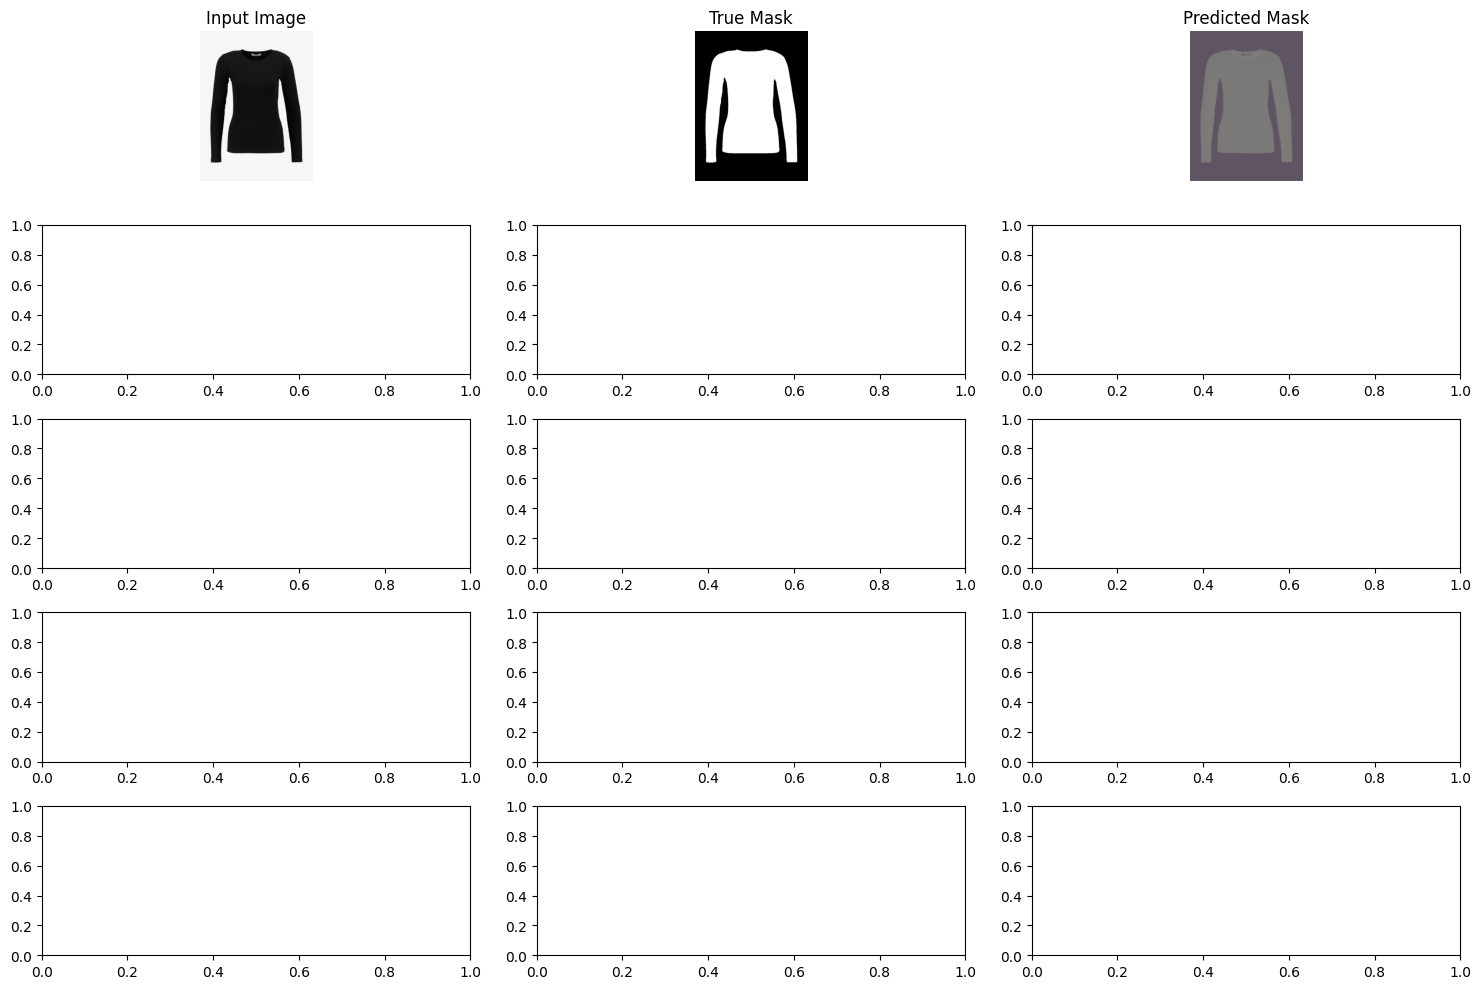

In [19]:
print("Step5")
visualize_predictions(model, val_loader)

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
